# Fonts

Here we convert some fonts to binary format, so that it can be saved in the micropython's memory.

We use an external tool for handling the conversion, and the command should look like 

```bash
> convert -background none -fill black -font VCR_OSD_MONO_1.001.ttf -pointsize 21 label:"z" +repage -depth 1 z.png
```

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'png'

import subprocess

Populating the interactive namespace from numpy and matplotlib


Here we define the characters we want to convert. When it is known that only a subset, e.g., only numbers are required, the font's memory footprint can be reduced by dropping the unnecessary characters.

In [2]:
lower_case_letters = 'abcdefghijklmnopqrstuvwxyz'
upper_case_letters = lower_case_letters.upper()
numbers = '0123456789'
punctuation = ',;.?!@#$%^&*()+-/_'

This functions calls the linux utility *convert* to produce a png image from the font glyphs. When a proper python tool, e.g., *freetype* is available, it could be inserted here.

In [72]:
def convert_font_to_matrix(fontfile, fontsize):
    # The coordinate systems of the ILI and SSD displays are different, 
    # therefore, one can't take the same font descriptions
    dic = {}
    for c in lower_case_letters + upper_case_letters + numbers + punctuation:
        command = ['convert', '-background', 'none', '-fill', 'black', '-font', '%s'%fontfile, 
                   '-pointsize', '%d'%fontsize, 'label:%c'%c, '+repage', '-depth', '1', '/dev/shm/font.png']
        subprocess.call(command)
        font_matrix = sum(imread('/dev/shm/font.png'), 2)
        nz = nonzero(sum(font_matrix, 0, dtype='int'))
        dic[c] = font_matrix[:,nz[0][0]:nz[0][-1]]
    return dic

These two functions are used to visually inspect the fonts. They take the font dictionary produced by convert_font_to_matrix, and display either a character, or an arbitrary string.

In [4]:
def draw_character(char):
    fig, (ax) = subplots(1)
    pcolormesh(flipud(char))
    ax.set_aspect(1)
    
def draw_string(font, string):
    fig, (ax) = subplots(1)
    (h, w) = shape(font['0'])
    zeroarray = zeros((h, 1))
    m = concatenate([concatenate([flipud(font[char]), zeroarray], 1) for char in string], 1)        
    pcolormesh(m)
    ax.set_aspect(1)

In [76]:
font = convert_font_to_matrix('FreeSans.ttf', 32)

The conversion to matrices leaves a huge white space on the bottom and the top of the fonts, so we have to remove that.

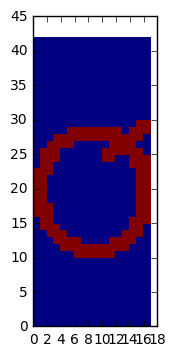

In [58]:
draw_character(font['Q'])

In [7]:
def font_sizer(font):
    # We have to trim the empty pixels in the font dictionary
    l = array(sum(font['0'], 1, dtype='int'))
    new_font = {}
    for k in font.keys():
        l += sum(font[k], 1, dtype='int')
    nz = nonzero(l)
    for k in font.keys():
        new_font[k] = font[k][nz[0][0]:nz[0][-1],:]
    return new_font

In [59]:
font = font_sizer(font)

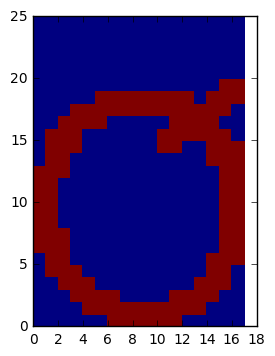

In [60]:
draw_character(font['Q'])

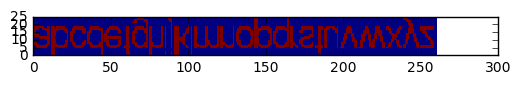

In [61]:
draw_string(font, lower_case_letters)

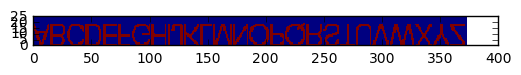

In [62]:
draw_string(font, upper_case_letters)

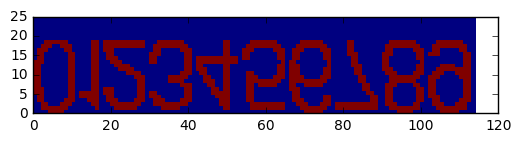

In [63]:
draw_string(font, numbers)

Here we convert the font matrix to a binary (hex) string. The widths are not fixed, the host should determine that from the lengths of the hex strings and the height of the character.

In [64]:
def array_to_byte(arr):
    byte = uint8(0)
    for bit in arr:
        byte <<= 1
        byte |= bit
    return uint8(byte)

In [74]:
def font_to_binary(font, display='ili'):
    dic = {}
    for k in font.keys():
        font_matrix = array(font[k], dtype='int')
        if display in ('ili0'):
            font_matrix = rot90(font_matrix)
        if display in ('ili90'):
            font_matrix = flipud(font_matrix)
        font_matrix = reshape(font_matrix, -1, order='F')
        # Here we have to pad the array, so that we can work with whole bytes
        font_matrix = pad(font_matrix, (0, abs(len(font_matrix)%(-8))), 'constant', constant_values=0)
#         font_matrix = reshape(font_matrix, (len(font_matrix)/8, 8))
        val = list([])
        for i in range(0, len(font_matrix), 8):
            val.append(array_to_byte(font_matrix[i:i+8]))
#         for i in range(shape(font_matrix)[0]):
#             val.append(array_to_byte(font_matrix[i, :]))
        dic[k] = val #''.join(['\\x{:02x}'.format(b) for b in val])
    return dic

In [77]:
binary_font = font_to_binary(font)

In [67]:
def font_footprint(font):
    # returns the number of bytes used by the font
    binary_font = font_to_binary(font)
    return sum([len(binary_font[l]) for l in binary_font.keys()])

In [79]:
len(numbers+lower_case_letters+upper_case_letters+punctuation)

80

In [78]:
font_footprint(font)

7326

In [69]:
def save_font(fn, font, fontname, mode='a'):
    fs = shape(font[list(font.keys())[0]])[0]
    binary_font = font_to_binary(font)
    with open(fn, mode) as fout:
        fout.write('\n\nclass %s(object):\n\n'%fontname)
        fout.write('\tdef __init__(self):\n\t\t')
        fout.write('self.font = {\n\t\t\t' + ''.join('"%s": %s,\\\n\t\t\t'%(key, bytes(val)) for key, val in sorted(binary_font.items())) + '}')
        fout.write('\n\n\tdef height(self): return %d\n'%fs)

In [34]:
save_font('font.py', font, 'FreeSans25', mode='w')

In [45]:
font = convert_font_to_matrix('FreeSans.ttf', 25)
font = font_sizer(font)
binary_font = font_to_binary(font)

In [ ]:
draw_character()

In [75]:
for fs in (12, 16, 20, 24, 28, 32):
    font = convert_font_to_matrix('FreeSans.ttf', fs)
    font = font_sizer(font)
    binary_font = font_to_binary(font)
    save_font('freesans.py', font, 'FreeSans%d'%fs, mode='a')

In [49]:
from freesans import FreeSans24

f = FreeSans24()

f.font['+']

b'\x00\x0c\x00\x00\x18\x00\x000\x00\x00`\x00\x00\xc0\x00?\xfc\x00\x7f\xf8\x00\x06\x00\x00\x0c\x00\x00\x18\x00\x000\x00'

In [54]:
def display_character(x, y, char, font):
    h = font.height() #font.height()
    c = font.font[char]
    w, _ = divmod(len(c)*8, h)
    mat = zeros((h, w))
    k, l = 0, 0
    byte = 128
    for j in range(w):
        for i in range(h):
            if c[k] & byte: mat[i, j] = 1
            l += 1
            byte >>= 1
            if l == 8:
                k += 1
                byte = 128
#                 print(byte)
                l = 0
    draw_character(mat)
    return mat

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  1

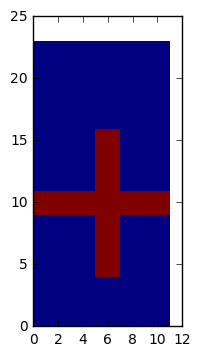

In [55]:
display_character(0, 0, '+', f)

In [40]:
draw_character(f['0'])

TypeError: 'FreeSans24' object is not subscriptable